In [1]:
import pandas as pd
import seaborn as sns
from subpred.ontology import EVIDENCE_CODE_TO_DESCRIPTION, GeneOntology, add_go_ancestors, ChebiOntology
from subpred.util import load_df


The purpose of this notebook is to find a set of substrate annotation labels that divide the transporters in *E. coli* into classes which are large enough for training ML models. The labels should have minimal overlap in terms of annotated proteins, and span as much of the genome as possible. Each selected label will have a minimal number of annotated proteins. 

We will try to a automate this process with a greedy algorithm removes the annotation with the largest overlap to the rest of the dataset in every step.

There are several sources of substrate annotations:

- ChEBI annotations in TCDB
- ChEBI annotations from EBI
- Gene Ontology Molecular function
- A combination of the above, for example by filtering proteins for transmembrane transport GO terms and then annotating with EBI.




## Dataset

As a first dataset, we will use *E. coli* again. Trying a version of this dataset that is clustered with cd-hit, and a meta-organism dataset, could also be interesting. 

In [2]:
df_uniprot = load_df("uniprot")
df_uniprot

,gene_names,protein_names,reviewed,protein_existence,sequence,organism_id
Uniprot,,,,,,
A0A0C5B5G6,MT-RNR1,Mitochondrial-derived peptide MOTS-c (Mitochon...,True,1,MRWQEMGYIFYPRKLR,9606
A0A1B0GTW7,CIROP LMLN2,Ciliated left-right organizer metallopeptidase...,True,1,MLLLLLLLLLLPPLVLRVAASRCLHDETQKSVSLLRPPFSQLPSKS...,9606
A0JNW5,BLTP3B KIAA0701 SHIP164 UHRF1BP1L,Bridge-like lipid transfer protein family memb...,True,1,MAGIIKKQILKHLSRFTKNLSPDKINLSTLKGEGELKNLELDEEVL...,9606
A0JP26,POTEB3,POTE ankyrin domain family member B3,True,1,MVAEVCSMPAASAVKKPFDLRSKMGKWCHHRFPCCRGSGKSNMGTS...,9606
A0PK11,CLRN2,Clarin-2,True,1,MPGWFKKAWYGLASLLSFSSFILIIVALVVPHWLSGKILCQTGVDL...,9606
...,...,...,...,...,...,...
X5L4R4,NOD-2,Nucleotide-binding oligomerization domain-cont...,False,2,MSPGCYKGWPFNCHLSHEEDKRRNETLLQEAETSNLQITASFVSGL...,586796
X5MBL2,GT34D,"Putative galacto(Gluco)mannan alpha-1,6-galact...",False,2,KVLYDRAFNSSDDQSALVYLLLKEKDKWADRIFIEHKYYLNGYWLD...,3352
X5MFI4,GT34D,"Putative galacto(Gluco)mannan alpha-1,6-galact...",False,2,MDEDVLCKGPLHGGSARSLKGSLKRLKRIMESLNDGLIFMGGAVSA...,3352


In [3]:
df_uniprot_ecoli = df_uniprot[df_uniprot.organism_id == 83333].drop("organism_id", axis=1)
df_uniprot_ecoli

,gene_names,protein_names,reviewed,protein_existence,sequence
Uniprot,,,,,
P00509,aspC b0928 JW0911,Aspartate aminotransferase (AspAT) (EC 2.6.1.1...,True,1,MFENITAAPADPILGLADLFRADERPGKINLGIGVYKDETGKTPVL...
P00803,lepB b2568 JW2552,Signal peptidase I (SPase I) (EC 3.4.21.89) (L...,True,1,MANMFALILVIATLVTGILWCVDKFFFAPKRRERQAAAQAAAGDSL...
P00804,lspA lsp b0027 JW0025,Lipoprotein signal peptidase (EC 3.4.23.36) (P...,True,1,MSQSICSTGLRWLWLVVVVLIIDLGSKYLILQNFALGDTVPLFPSL...
P00861,lysA b2838 JW2806,Diaminopimelate decarboxylase (DAP decarboxyla...,True,1,MPHSLFSTDTDLTAENLLRLPAEFGCPVWVYDAQIIRRQIAALKQF...
P00946,manA pmi b1613 JW1605,Mannose-6-phosphate isomerase (EC 5.3.1.8) (Ph...,True,1,MQKLINSVQNYAWGSKTALTELYGMENPSSQPMAELWMGAHPKSSS...
...,...,...,...,...,...
P76154,ydfK b1544 JW1537,Cold shock protein YdfK,True,2,MKSKDTLKWFPAQLPEVRIILGDAVVEVAKQGRPINTRTLLDYIEG...
P0AEG8,dsrB b1952 JW1936,Protein DsrB,True,2,MKVNDRVTVKTDGGPRRPGVVLAVEEFSEGTMYLVSLEDYPLGIWF...
P33668,ybbC b0498 JW0487,Uncharacterized protein YbbC,True,2,MKYSSIFSMLSFFILFACNETAVYGSDENIIFMRYVEKLHLDKYSV...


In [4]:
assert not df_uniprot_ecoli.gene_names.isnull().any()
assert not df_uniprot_ecoli.protein_names.isnull().any()
assert not df_uniprot_ecoli.sequence.isnull().any()

In [5]:
df_uniprot_ecoli[["reviewed", "protein_existence"]].groupby(["reviewed", "protein_existence"]).apply(len)

reviewed  protein_existence
False     1                       1
          2                       1
True      1                    3118
          2                     164
dtype: int64

In [6]:
df_uniprot_ecoli[~df_uniprot_ecoli.reviewed]

,gene_names,protein_names,reviewed,protein_existence,sequence
Uniprot,,,,,
A0A7H2C7B0,speFL ECK4660 b4803,Leader peptide SpeFL (Arrest peptide SpeFL),False,2,MENNSRTMPHIRRTTHIMKFAHRNSFDFHFFNAR
A0A0A6YVN8,D-tagatose 3-epimerase,D-tagatose 3-epimerase,False,1,MNKVGMFYTYWSTEWMVDFPATAKRIAGLGFDLMEISLGEFHNLSD...


Removing the two unreviewed proteins, not worth it keeping them in the dataset.

In [7]:
df_uniprot_ecoli = df_uniprot_ecoli[df_uniprot_ecoli.reviewed].drop("reviewed", axis=1)

Distribution of sequence lengths:

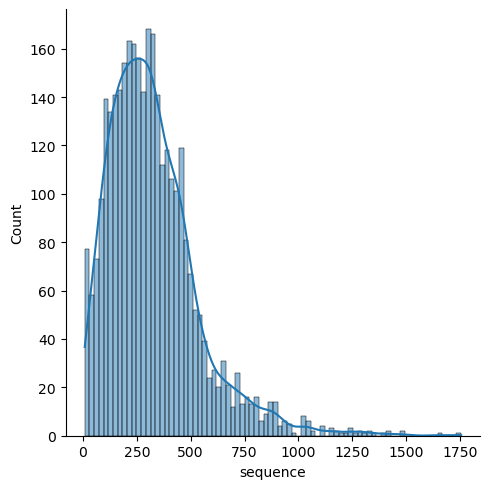

In [8]:
len_sequences = df_uniprot_ecoli.sequence.apply(len)
sns.displot(len_sequences, kde=True, bins=80)

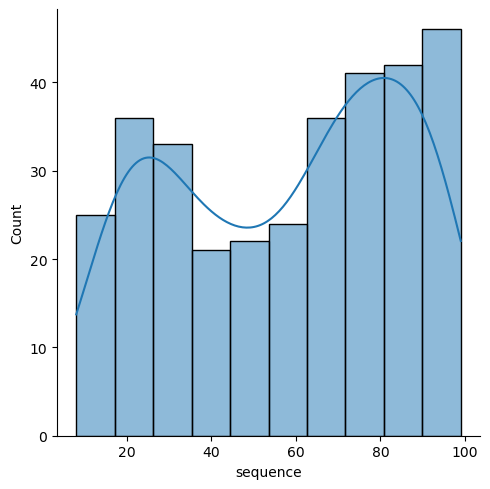

In [9]:
sns.displot(len_sequences[len_sequences < 100], kde=True)

In [10]:
df_uniprot_ecoli[df_uniprot_ecoli.sequence.apply(len) < 40]

,gene_names,protein_names,protein_existence,sequence
Uniprot,,,,
P56100,cydX ybgT b4515 JW0724,Cytochrome bd-I ubiquinol oxidase subunit X (E...,1,MWYFAWILGTLLACSFGVITALALEHVESGKAGQEDI
P0DTV7,speFL b4803,Leader peptide SpeFL (Arrest peptide SpeFL),1,MENNSRTMPHIRRTTHIMKFAHRNSFDFHFFNAR
P36937,kdpF b4513 JW0687,Potassium-transporting ATPase KdpF subunit (AT...,1,MSAGVITGVLLVFLLLGYLVYALINAEAF
A5A616,mgtS yneM b4599 JW1527.1,Small protein MgtS,1,MLGNMNVFMAVLGIILFSGFLAAYFSHKWDD
A5A627,tisB ysdB b4618 JW3649,Small toxic protein TisB (LexA-regulated prote...,1,MNLVDIAILILKLIVAALQLLDAVLKYLK
...,...,...,...,...
P0DSF6,yecV b4778,Protein YecV,1,MSIFRIHLDGNKKA
P0DSF9,evgL b4781,Protein EvgL,1,MLHCKGNNL
P0DSH7,ysgD b4799,Protein YsgD,1,MDTPSRYWLTILSSRINS


## Annotations

In [11]:
df_goa_uniprot = load_df("go")
df_goa_uniprot

,Uniprot,qualifier,go_id,evidence_code,aspect
0,A0A009FND8,enables,GO:0000166,IEA,F
1,A0A009FND8,enables,GO:0005524,IEA,F
2,A0A009FND8,enables,GO:0051082,IEA,F
3,A0A009FND8,enables,GO:0140662,IEA,F
4,A0A009FND8,involved_in,GO:0006457,IEA,P
...,...,...,...,...,...
7452013,Z9JND5,enables,GO:0000166,IEA,F
7452014,Z9JND5,enables,GO:0005524,IEA,F
7452015,Z9JND5,enables,GO:0051082,IEA,F
7452016,Z9JND5,enables,GO:0140662,IEA,F


In [12]:
df_goa_uniprot_ecoli = df_goa_uniprot[df_goa_uniprot.Uniprot.isin(df_uniprot_ecoli.index)]
df_goa_uniprot_ecoli = df_goa_uniprot_ecoli.assign(evidence_description = df_goa_uniprot_ecoli.evidence_code.map(EVIDENCE_CODE_TO_DESCRIPTION))
df_goa_uniprot_ecoli = df_goa_uniprot_ecoli.reset_index(drop=True)
df_goa_uniprot_ecoli

,Uniprot,qualifier,go_id,evidence_code,aspect,evidence_description
0,A5A615,located_in,GO:0005886,IDA,C,experimental_evidence
1,A5A615,located_in,GO:0005886,IEA,C,electronic_annotation
2,A5A615,located_in,GO:0005886,RCA,C,computational_analysis
3,A5A615,located_in,GO:0016020,IEA,C,electronic_annotation
4,A5A616,acts_upstream_of_or_within,GO:0010350,IEP,P,experimental_evidence
...,...,...,...,...,...,...
40133,Q93K97,involved_in,GO:0006753,IBA,P,phylogenetically_inferred
40134,Q93K97,involved_in,GO:0019693,IBA,P,phylogenetically_inferred
40135,Q93K97,is_active_in,GO:0005829,IBA,C,phylogenetically_inferred
40136,Q93K97,located_in,GO:0005829,HDA,C,experimental_evidence_high_throughput


In [13]:
go_owl = GeneOntology("../data/raw/ontologies/go.owl")

In [14]:
df_goa_uniprot_ecoli = add_go_ancestors(df_goa_uniprot_ecoli, go_owl)

Is there any go term that does not have a label?

In [15]:
df_goa_uniprot_ecoli.go_id.map(go_owl.get_label).isnull().any()

False

Are all GO terms up-to-date with the OWL file?

In [16]:
(df_goa_uniprot_ecoli.go_id.map(go_owl.update_identifer).map(go_owl.decode_identifier) == df_goa_uniprot_ecoli.go_id).all()

True

Deprecated terms?

In [17]:
df_goa_uniprot_ecoli.go_id.map(go_owl.is_deprecated).any()

False

### ChEBI (TCDB)

In [18]:
chebi_owl = ChebiOntology("../data/raw/ontologies/chebi.owl")

In [19]:
df_tcdb_substrates = load_df("tcdb_substrates")
df_tcdb_substrates

,tcdb_id,variable,value
0,2.A.52.2.2,chebi_id,CHEBI:23337
1,2.A.52.2.2,chebi_id,CHEBI:25517
2,2.A.22.2.5,chebi_id,CHEBI:9175
3,2.A.22.2.5,chebi_id,CHEBI:8345
4,2.A.90.2.4,chebi_id,CHEBI:8816
...,...,...,...
34308,2.A.47.1.5,Uniprot,Q9W7I2
34309,2.A.18.3.2,Uniprot,Q9XE48
34310,2.A.18.3.3,Uniprot,Q9XE49
34311,2.A.29.11.2,Uniprot,Q9ZNY4


In [20]:
df_tcdb_substrates.variable.unique()

array(['chebi_id', 'chebi_term', 'Uniprot'], dtype=object)

In [21]:
df_uniprot_tcdb = (
    df_tcdb_substrates[df_tcdb_substrates.variable == "Uniprot"]
    .drop("variable", axis=1)
    .rename(columns={"value": "Uniprot"})[["Uniprot", "tcdb_id"]]
)
df_uniprot_tcdb = df_uniprot_tcdb.sort_values(
    df_uniprot_tcdb.columns.tolist()
).reset_index(drop=True)
df_uniprot_tcdb[df_uniprot_tcdb.Uniprot.duplicated(keep=False)]
# TODO duplicated


,Uniprot,tcdb_id
272,C4IN73,2.A.49.2.14
273,C4IN73,9.B.153.3.18
350,D5ARG8,2.A.88.1.3
351,D5ARG8,3.A.1.25.7
741,O15533,8.A.196.1.1
...,...,...
6946,Q9NV96,8.A.27.1.5
7163,Q9UBQ0,9.A.3.1.1
7164,Q9UBQ0,9.A.3.1.2
7434,Q9Y3Q4,1.A.1.5.10


In [22]:
df_tcdb_chebi = (
    df_tcdb_substrates[df_tcdb_substrates.variable == "chebi_id"]
    .drop("variable", axis=1)
    .rename(columns={"value": "chebi_id"})
    .drop_duplicates()
    .sort_values(["tcdb_id", "chebi_id"])
    .reset_index(drop=True)
)
df_tcdb_chebi

,tcdb_id,chebi_id
0,1.A.1.1.1,CHEBI:5585
1,1.A.1.1.1,CHEBI:8345
2,1.A.1.10.1,CHEBI:9175
3,1.A.1.10.10,CHEBI:9175
4,1.A.1.10.11,CHEBI:9175
...,...,...
13397,9.B.9.1.1,CHEBI:9885
13398,9.B.97.1.7,CHEBI:18154
13399,9.B.97.2.3,CHEBI:6486
13400,9.B.99.1.1,CHEBI:25367


Are there deprecated identifiers?

In [23]:
df_tcdb_chebi.chebi_id.map(chebi_owl.is_deprecated).value_counts()

True     7823
False    5579
Name: chebi_id, dtype: int64

Yes, most identifiers are deprecated. We can try updating them:

In [24]:
df_tcdb_chebi.chebi_id = df_tcdb_chebi.chebi_id.map(chebi_owl.update_identifer).map(chebi_owl.decode_identifier)
df_tcdb_chebi

,tcdb_id,chebi_id
0,1.A.1.1.1,CHEBI:15377
1,1.A.1.1.1,CHEBI:29103
2,1.A.1.10.1,CHEBI:29101
3,1.A.1.10.10,CHEBI:29101
4,1.A.1.10.11,CHEBI:29101
...,...,...
13397,9.B.9.1.1,CHEBI:17775
13398,9.B.97.1.7,CHEBI:18154
13399,9.B.97.2.3,CHEBI:18059
13400,9.B.99.1.1,CHEBI:25367


No more deprecated idenntifiers left:

In [25]:
df_tcdb_chebi.chebi_id.map(chebi_owl.is_deprecated).value_counts()

False    13402
Name: chebi_id, dtype: int64

Only about 11% of substrates are completely unknown.

Adding direct ancestor molecules:

In [26]:
df_tcdb_chebi.chebi_id = df_tcdb_chebi.chebi_id.map(go_owl.get_ancestors)

In [30]:
df_tcdb_chebi = df_tcdb_chebi.explode("chebi_id").drop_duplicates().reset_index(drop=True)

Adding names of chebi entries:

In [31]:
df_tcdb_chebi["chebi_term"] = df_tcdb_chebi.chebi_id.map(chebi_owl.get_label)
df_tcdb_chebi

,tcdb_id,chebi_id,chebi_term
0,1.A.1.1.1,CHEBI:33304,chalcogen molecular entity
1,1.A.1.1.1,CHEBI:24431,chemical entity
2,1.A.1.1.1,CHEBI:33693,oxygen hydride
3,1.A.1.1.1,CHEBI:24835,inorganic molecular entity
4,1.A.1.1.1,CHEBI:37176,mononuclear parent hydride
...,...,...,...
205204,9.B.99.1.1,CHEBI:36357,polyatomic entity
205205,9.B.99.1.1,CHEBI:25367,molecule
205206,9.B.99.1.2,CHEBI:24432,biological role
205207,9.B.99.1.2,CHEBI:50906,role


Any labels that are empty or null?

In [32]:
df_tcdb_chebi.chebi_term.isnull().any()

False

How many substrates are just "molecule"?

In [47]:
# TODO systems that only have molecule. groupby
# df_tcdb_chebi.drop_duplicates().groupby("tcdb_id").apply(lambda x: x.shape[0] == 1).value_counts()

False    8441
dtype: int64

In [39]:
df_substrates_tcdb = pd.merge(df_uniprot_tcdb, df_tcdb_chebi,on="tcdb_id", how="inner")
df_substrates_tcdb

,Uniprot,tcdb_id,chebi_id,chebi_term
0,A0A061ACU2,1.A.75.1.8,CHEBI:36916,cation
1,A0A061ACU2,1.A.75.1.8,CHEBI:24431,chemical entity
2,A0A061ACU2,1.A.75.1.8,CHEBI:23367,molecular entity
3,A0A061ACU2,1.A.75.1.8,CHEBI:24870,ion
4,A0A1L8F5J9,1.A.10.1.12,CHEBI:24431,chemical entity
...,...,...,...,...
145631,W8VZW3,3.E.1.6.14,CHEBI:25806,oxygen molecular entity
145632,W8VZW3,3.E.1.6.14,CHEBI:33302,pnictogen molecular entity
145633,W8VZW3,3.E.1.6.14,CHEBI:33608,hydrogen molecular entity
145634,W8VZW3,3.E.1.6.14,CHEBI:51143,nitrogen molecular entity


In [43]:
df_substrates_tcdb_ecoli = df_substrates_tcdb[df_substrates_tcdb.Uniprot.isin(df_uniprot_ecoli.index)].reset_index(drop=True)
df_substrates_tcdb_ecoli

,Uniprot,tcdb_id,chebi_id,chebi_term
0,A5A627,1.C.103.1.1,CHEBI:36914,inorganic ion
1,A5A627,1.C.103.1.1,CHEBI:24431,chemical entity
2,A5A627,1.C.103.1.1,CHEBI:23367,molecular entity
3,A5A627,1.C.103.1.1,CHEBI:22563,anion
4,A5A627,1.C.103.1.1,CHEBI:24835,inorganic molecular entity
...,...,...,...,...
17865,Q6BF25,1.C.64.1.13,CHEBI:36914,inorganic ion
17866,Q6BF25,1.C.64.1.13,CHEBI:24431,chemical entity
17867,Q6BF25,1.C.64.1.13,CHEBI:23367,molecular entity
17868,Q6BF25,1.C.64.1.13,CHEBI:24835,inorganic molecular entity
